In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3830884/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "SharkDAO"
SPLITS_FREQ = "3d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-04-27"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 471 non-null    object        
 1   author             471 non-null    object        
 2   date               471 non-null    datetime64[us]
 3   start              471 non-null    datetime64[us]
 4   end                471 non-null    datetime64[us]
 5   platform_proposal  471 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 22.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7577 entries, 0 to 7576
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        7577 non-null   object        
 1   proposal  7577 non-null   object        
 2   voter     7577 non-null   object        
 3   date      7577 non-null   datetime64[us]
dtypes: d

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/SharkDAO/baseline/folds-info_3d_normalize.parquet
fold
2023-06-21    7374
2023-06-24    7390
2023-06-27    7397
2023-06-30    7399
2023-07-03    7423
2023-07-06    7458
2023-07-09    7497
2023-07-12    7516
2023-07-15    7534
2023-07-18    7561
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W25,5,3,1,0.60,3.00,10,6,2.00,1.67
2023-W25,6,14,4,2.33,3.50,12,7,2.00,1.71
2023-W26,5,17,4,3.40,4.25,5,5,1.00,1.00
2023-W26,4,10,5,2.50,2.00,24,15,6.00,1.60
2023-W27,7,18,7,2.57,2.57,53,16,7.57,3.31
2023-W27,8,44,14,5.50,3.14,38,15,4.75,2.53
2023-W27,6,31,17,5.17,1.82,34,25,5.67,1.36
2023-W28,6,40,22,6.67,1.82,23,18,3.83,1.28
2023-W28,9,38,25,4.22,1.52,37,12,4.11,3.08


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W25 & 5 & 3 & 1 & 0.60 & 3.00 & 10 & 6 & 2.00 & 1.67 \\
2023-W25 & 6 & 14 & 4 & 2.33 & 3.50 & 12 & 7 & 2.00 & 1.71 \\
2023-W26 & 5 & 17 & 4 & 3.40 & 4.25 & 5 & 5 & 1.00 & 1.00 \\
2023-W26 & 4 & 10 & 5 & 2.50 & 2.00 & 24 & 15 & 6.00 & 1.60 \\
2023-W27 & 7 & 18 & 7 & 2.57 & 2.57 & 53 & 16 & 7.57 & 3.31 \\
2023-W27 & 8 & 44 & 14 & 5.50 & 3.14 & 38 & 15 & 4.75 & 2.53 \\
2023-W27 & 6 & 31 & 17 & 5.17 & 1.82 & 34 & 25 & 5.67 & 1.36 \\
2023-W28 & 6 & 40 & 22 & 6.67 & 1.82 & 23 & 18 & 3.83 & 1.28 \\
2023-W28 & 9 & 38 & 25 & 4.22 & 1.52 & 37 & 12 & 4.11 & 3.08 \\
2023-W29 & 6 & 23 & 8 & 3.83 & 2.88 & 16 & 6 & 2.67 & 2.67 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/237 [00:00<?, ?it/s]

Warning, empty test fold 0 (2021-08-09 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2021-08-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2021-08-15 00:00:00), all ok since 1 folds ago
Warning, test fold 3 (2021-08-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 4 (2021-08-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 5 (2021-08-24 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 6 (2021-08-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 7 (2021-08-30 00:00:00), all ok since 5 folds ago
Warning, test fold 8 (2021-09-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 9 (2021-09-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 10 (2021-09-08 00:00:00), all ok since 3 folds ago
Warning, empty test fold 11 (2021-09-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 12 (2021-09-14 00:00:00), all ok since 1 folds ago
Warning, test fold 13 (2021-09-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 14 (2021-09-20 00:00:00), all ok since 2 folds ago
Warning, test fold 15 (2021-09-23 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 16 (2021-09-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 17 (2021-09-29 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 18 (2021-10-02 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 19 (2021-10-05 00:00:00), all ok since 5 folds ago
Warning, empty test fold 20 (2021-10-08 00:00:00), all ok since 1 folds ago


Warning, test fold 21 (2021-10-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 22 (2021-10-14 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 23 (2021-10-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 24 (2021-10-20 00:00:00), all ok since 4 folds ago
Warning, test fold 25 (2021-10-23 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 26 (2021-10-26 00:00:00), all ok since 2 folds ago
Warning, empty test fold 27 (2021-10-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 28 (2021-11-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 29 (2021-11-04 00:00:00), all ok since 1 folds ago


Warning, test fold 30 (2021-11-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 31 (2021-11-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 32 (2021-11-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 33 (2021-11-16 00:00:00), all ok since 4 folds ago
Warning, empty test fold 34 (2021-11-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 35 (2021-11-22 00:00:00), all ok since 1 folds ago
Warning, test fold 36 (2021-11-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 37 (2021-11-28 00:00:00), all ok since 2 folds ago
Warning, test fold 38 (2021-12-01 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 40 (2021-12-07 00:00:00), all ok since 3 folds ago
Warning, empty test fold 41 (2021-12-10 00:00:00), all ok since 1 folds ago


Warning, test fold 42 (2021-12-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 43 (2021-12-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 44 (2021-12-19 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 45 (2021-12-22 00:00:00), all ok since 4 folds ago
Warning, empty test fold 46 (2021-12-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 47 (2021-12-28 00:00:00), all ok since 1 folds ago
Warning, test fold 48 (2021-12-31 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 49 (2022-01-03 00:00:00), all ok since 2 folds ago
Warning, empty test fold 50 (2022-01-06 00:00:00), all ok since 1 folds ago


Warning, test fold 51 (2022-01-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 52 (2022-01-12 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 53 (2022-01-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 54 (2022-01-18 00:00:00), all ok since 4 folds ago
Warning, empty test fold 55 (2022-01-21 00:00:00), all ok since 1 folds ago


Warning, test fold 56 (2022-01-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 57 (2022-01-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 58 (2022-01-30 00:00:00), all ok since 3 folds ago
Warning, empty test fold 59 (2022-02-02 00:00:00), all ok since 1 folds ago


Warning, test fold 60 (2022-02-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 61 (2022-02-08 00:00:00), all ok since 2 folds ago
Warning, empty test fold 62 (2022-02-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 63 (2022-02-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 64 (2022-02-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 65 (2022-02-20 00:00:00), all ok since 1 folds ago
Warning, test fold 66 (2022-02-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 67 (2022-02-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 68 (2022-03-01 00:00:00), all ok since 3 folds ago
Warning, test fold 69 (2022-03-04 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 70 (2022-03-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 71 (2022-03-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 72 (2022-03-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 73 (2022-03-16 00:00:00), all ok since 5 folds ago
Warning, test fold 74 (2022-03-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 75 (2022-03-22 00:00:00), all ok since 2 folds ago
Warning, test fold 76 (2022-03-25 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 77 (2022-03-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 78 (2022-03-31 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 79 (2022-04-03 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 80 (2022-04-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 81 (2022-04-09 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 84 (2022-04-18 00:00:00) with less than 5 open proposals (3). all ok since 3 folds ago


Warning, empty test fold 88 (2022-04-30 00:00:00), all ok since 13 folds ago
Warning, empty test fold 89 (2022-05-03 00:00:00), all ok since 1 folds ago


Warning, test fold 90 (2022-05-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 91 (2022-05-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 92 (2022-05-12 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 93 (2022-05-15 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 94 (2022-05-18 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 96 (2022-05-24 00:00:00), all ok since 7 folds ago
Warning, test fold 97 (2022-05-27 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 99 (2022-06-02 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, test fold 100 (2022-06-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 101 (2022-06-08 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 102 (2022-06-11 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 103 (2022-06-14 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 104 (2022-06-17 00:00:00), all ok since 8 folds ago
Warning, test fold 105 (2022-06-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 106 (2022-06-23 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 107 (2022-06-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 108 (2022-06-29 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 109 (2022-07-02 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 110 (2022-07-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 111 (2022-07-08 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 112 (2022-07-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 115 (2022-07-20 00:00:00) with less than 5 open proposals (1). all ok since 3 folds ago


Warning, test fold 116 (2022-07-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 117 (2022-07-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 118 (2022-07-29 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 119 (2022-08-01 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 120 (2022-08-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 121 (2022-08-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 122 (2022-08-10 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 123 (2022-08-13 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 124 (2022-08-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 125 (2022-08-19 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 126 (2022-08-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 127 (2022-08-25 00:00:00), all ok since 23 folds ago
Warning, test fold 128 (2022-08-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 129 (2022-08-31 00:00:00), all ok since 2 folds ago
Warning, test fold 130 (2022-09-03 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 131 (2022-09-06 00:00:00), all ok since 2 folds ago
Warning, test fold 132 (2022-09-09 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 133 (2022-09-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 134 (2022-09-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 135 (2022-09-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 136 (2022-09-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 137 (2022-09-24 00:00:00), all ok since 6 folds ago
Warning, test fold 138 (2022-09-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 139 (2022-09-30 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 140 (2022-10-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 142 (2022-10-09 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 143 (2022-10-12 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 144 (2022-10-15 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 145 (2022-10-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 147 (2022-10-24 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 148 (2022-10-27 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 149 (2022-10-30 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 150 (2022-11-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 151 (2022-11-05 00:00:00), all ok since 14 folds ago
Warning, test fold 152 (2022-11-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 153 (2022-11-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 154 (2022-11-14 00:00:00), all ok since 3 folds ago
Warning, test fold 155 (2022-11-17 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 156 (2022-11-20 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 157 (2022-11-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 158 (2022-11-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 159 (2022-11-29 00:00:00), all ok since 5 folds ago
Warning, test fold 160 (2022-12-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 162 (2022-12-08 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 164 (2022-12-14 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, test fold 168 (2022-12-26 00:00:00) with less than 5 open proposals (3). all ok since 4 folds ago


Warning, test fold 169 (2022-12-29 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 170 (2023-01-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 171 (2023-01-04 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 172 (2023-01-07 00:00:00), all ok since 13 folds ago
Warning, test fold 173 (2023-01-10 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 179 (2023-01-28 00:00:00) with less than 5 open proposals (3). all ok since 6 folds ago


Warning, test fold 180 (2023-01-31 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 186 (2023-02-18 00:00:00) with less than 5 open proposals (2). all ok since 6 folds ago


Warning, test fold 187 (2023-02-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 188 (2023-02-24 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 189 (2023-02-27 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 193 (2023-03-11 00:00:00) with less than 5 open proposals (3). all ok since 4 folds ago


Warning, test fold 194 (2023-03-14 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 198 (2023-03-26 00:00:00) with less than 5 open proposals (3). all ok since 4 folds ago


Warning, test fold 199 (2023-03-29 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 200 (2023-04-01 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 203 (2023-04-10 00:00:00) with less than 5 open proposals (3). all ok since 3 folds ago


Warning, test fold 204 (2023-04-13 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 205 (2023-04-16 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 206 (2023-04-19 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 207 (2023-04-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 208 (2023-04-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 217 (2023-05-22 00:00:00) with less than 5 open proposals (3). all ok since 9 folds ago


Warning, test fold 218 (2023-05-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 219 (2023-05-28 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 220 (2023-05-31 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 225 (2023-06-15 00:00:00) with less than 5 open proposals (4). all ok since 5 folds ago


Warning, test fold 230 (2023-06-30 00:00:00) with less than 5 open proposals (4). all ok since 5 folds ago


Max ok in a row: (23, Timestamp('2022-08-25 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/SharkDAO/baseline/openpop_3d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,...,237.000000,237.000000,237.000000,237.000000,235.000000,232.000000,232.000000,232.000000,232.000000,237.000000
mean,0.418226,0.272126,0.186478,0.097022,0.064681,0.009702,0.412678,0.495799,0.514332,0.519609,...,0.611768,0.611768,0.611768,0.496295,0.586647,0.608002,0.609625,0.609625,0.609625,0.110432
std,0.380736,0.214594,0.149517,0.079399,0.052933,0.007940,0.380073,0.393326,0.391899,0.392097,...,0.441351,0.441351,0.441351,0.390694,0.406578,0.406155,0.406535,0.406535,0.406535,0.026060
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068196
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084676
50%,0.333333,0.333333,0.200000,0.100000,0.066667,0.010000,0.333333,0.545259,0.599166,0.619290,...,1.000000,1.000000,1.000000,0.520000,0.708333,0.746795,0.750000,0.750000,0.750000,0.122438
75%,0.800000,0.400000,0.288889,0.147619,0.098413,0.014762,0.800000,0.872600,0.876977,0.876977,...,1.000000,1.000000,1.000000,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,0.125065
max,1.000000,0.787879,0.560000,0.300000,0.200000,0.030000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.290368


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/SharkDAO/baseline/perfect_3d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,...,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,0.789030,0.397804,0.253311,0.128495,0.085664,0.012850,0.789030,0.789030,0.789030,0.789030,...,0.789030,0.789030,0.789030,0.622684,0.771302,0.786325,0.789030,0.789030,0.789030,0.117022
std,0.408861,0.249446,0.170074,0.088719,0.059146,0.008872,0.408861,0.408861,0.408861,0.408861,...,0.408861,0.408861,0.408861,0.362758,0.401948,0.407646,0.408861,0.408861,0.408861,0.022751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072086
25%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.479167,0.850000,0.966667,1.000000,1.000000,1.000000,0.124716
50%,1.000000,0.400000,0.240000,0.120000,0.080000,0.012000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.708333,1.000000,1.000000,1.000000,1.000000,1.000000,0.128092
75%,1.000000,0.595745,0.366667,0.183333,0.122222,0.018333,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.958333,1.000000,1.000000,1.000000,1.000000,1.000000,0.129393
max,1.000000,0.937500,0.662500,0.400000,0.266667,0.040000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.139061


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,237,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,...,237.000000,237.000000,235.000000,232.000000,232.000000,232.000000,232.000000,237.000000,0.0,0.0
mean,2022-07-29 00:00:00,0.418226,0.272126,0.186478,0.097022,0.064681,0.009702,0.412678,0.495799,0.514332,...,0.611768,0.496295,0.586647,0.608002,0.609625,0.609625,0.609625,0.110432,NaN,NaN
min,2021-08-09 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068196,NaN,NaN
25%,2022-02-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084676,NaN,NaN
50%,2022-07-29 00:00:00,0.333333,0.333333,0.200000,0.100000,0.066667,0.010000,0.333333,0.545259,0.599166,...,1.000000,0.520000,0.708333,0.746795,0.750000,0.750000,0.750000,0.122438,NaN,NaN
75%,2023-01-22 00:00:00,0.800000,0.400000,0.288889,0.147619,0.098413,0.014762,0.800000,0.872600,0.876977,...,1.000000,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,0.125065,NaN,NaN
max,2023-07-18 00:00:00,1.000000,0.787879,0.560000,0.300000,0.200000,0.030000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.290368,NaN,NaN
std,NaN,0.380736,0.214594,0.149517,0.079399,0.052933,0.007940,0.380073,0.393326,0.391899,...,0.441351,0.390694,0.406578,0.406155,0.406535,0.406535,0.406535,0.026060,NaN,NaN


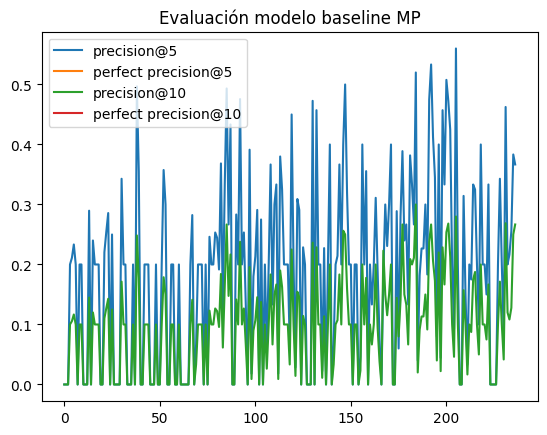

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,9.000000,9.000000,9.000000,9.000000,10.000000,0.0,0.0
mean,2023-07-04 12:00:00,0.280397,0.276647,0.271091,0.155462,0.103642,0.015546,0.270063,0.368180,0.477698,...,0.764451,0.402127,0.509333,0.639527,0.649403,0.649403,0.649403,0.123934,NaN,NaN
min,2023-06-21 00:00:00,0.000000,0.000000,0.083333,0.041667,0.027778,0.004167,0.000000,0.000000,0.116848,...,0.180556,0.000000,0.000000,0.424074,0.424074,0.424074,0.424074,0.108643,NaN,NaN
25%,2023-06-27 18:00:00,0.098214,0.154167,0.200000,0.102083,0.068056,0.010208,0.095714,0.176340,0.432692,...,0.643490,0.239583,0.400521,0.555556,0.611111,0.611111,0.611111,0.123639,NaN,NaN
50%,2023-07-04 12:00:00,0.225000,0.333333,0.236111,0.123889,0.082593,0.012389,0.225000,0.405668,0.453082,...,0.825000,0.444167,0.496319,0.625000,0.641667,0.641667,0.641667,0.125976,NaN,NaN
75%,2023-07-11 06:00:00,0.395833,0.354167,0.360714,0.230357,0.153571,0.023036,0.395833,0.514376,0.572837,...,1.000000,0.576389,0.645833,0.666667,0.666667,0.666667,0.666667,0.126961,NaN,NaN
max,2023-07-18 00:00:00,0.777778,0.479167,0.462500,0.268750,0.179167,0.026875,0.777778,0.782357,0.866194,...,1.000000,0.869048,0.916667,0.916667,0.916667,0.916667,0.916667,0.129676,NaN,NaN
std,NaN,0.256751,0.158603,0.114085,0.080097,0.053398,0.008010,0.244864,0.239887,0.196135,...,0.280397,0.274239,0.248535,0.169435,0.166660,0.166660,0.166660,0.005961,NaN,NaN
